## ExMAS
> Equilibrium matching - expieriments for the paper

---
# Toy network

* 10 requests
* 23 possible rides

#### Content:

* incidence matrix
* costs as a column sums
* costs for individuals
* solution: system optimal for users
* solution: system optimal for operator

In [2]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display
pd.options.display.max_columns = None

In [4]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching, evaluate_shareability
from ExMAS.extras import games, pricings, prunings

In [5]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/game_toy.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
#inData.requests = ExMAS.utils.load_requests('ExMAS/spinoffs/game/toy.csv')

In [6]:
params.nP = 50
params.shared_discount = 0.3

In [7]:
inData = ExMAS.utils.generate_demand(inData, params)

<AxesSubplot:xlabel='kind'>

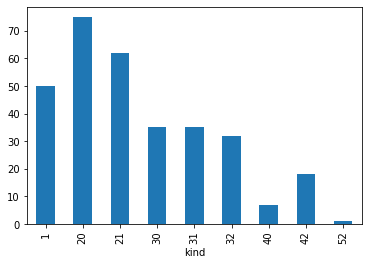

In [8]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures
inData.sblts.rides.groupby('kind').size().plot(kind='bar')

In [11]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [12]:
params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)
params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

In [14]:
inData = ExMAS.extras.pricings.update_costs(inData, params)
inData.sblts.rides_multi_index.tail(9)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
313 26   313         26    True       4    99       586  1702    212   
    28   313         28    True       4   101       586  1149    143   
    41   313         41    True       4   157       586  3531    441   
    47   313         47    True       4   166       586  1390    173   
314 26   314         26    True       5    99       733  1702    212   
    19   314         19    True       5    80       733  2458    307   
    28   314         28    True       5   101       733  1149    143   
    41   314         41    True       5   157       733  3531    441   
    47   314         47    True       5   166       733  1390    173   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
313 26       270  -24.5     4688   3.1663   1.073625          8.902800   
    28       204   39.5     4688   3.1663   0.921375          8.902800   
    41       462   41.5     4688   3.1663   1.834875          8.902800   
    47       394  100.5     4688   3.1663   1.906625          8.902800   
314 26       284  -17.5     5864  3.83515   1.085875         13.823275   
    19       702   32.5     5864  3.83515   2.627625         13.823275   
    28       304   60.5     5864  3.83515   1.381625         13.823275   
    41       595   62.5     5864  3.83515   2.410625         13.823275   
    47       527  121.5     5864  3.83515   2.482375         13.823275   

        cost_single  total_singles  residual_user  
313 26      2.20660        9.80045      -0.897650  
    28      1.65115        9.80045      -0.897650  
    41      4.05005        9.80045      -0.897650  
    47      1.89265        9.80045      -0.897650  
314 26      2.20660       12.77180       1.051475  
    19      2.97135       12.77180       1.051475  
    28      1.65115       12.77180       1.051475  
    41      4.05005       12.77180       1.051475  
    47      1.89265       12.77180       1.051475

In [15]:
def subgroup_split(inData):

    def get_subgroup_price(r):
        indexes = r.indexes_set
        subgroups = r.subgroups
        subgroup_indexes = rides.loc[subgroups][['indexes_set']]
        
        prices = dict()
        while len(indexes)>0:
            effs = rides.loc[subgroups].cost_efficiency
            J = effs.idxmin()
            z = effs.min()
            indexes = indexes - rides.loc[J].indexes_set
            subgroup_indexes = rides.loc[subgroups][['indexes_set']]
            subgroup_indexes['f'] = subgroup_indexes.apply(lambda x: len(rides.loc[J].indexes_set.intersection(x.indexes_set))==0,axis = 1 )
            subgroups = subgroup_indexes[subgroup_indexes.f].index
            
    
            for i in rides.loc[J].indexes_set:
                prices[i] = z
        return prices


    rm = inData.sblts.rides_multi_index
    rides = inData.sblts.rides
    prices = dict()
    for i, r in rides.iterrows():
        prices.update(get_subgroup_price(r))
        
    rm['SUBGROUP'] = rm.apply(lambda x: prices[x.traveller], axis = 1)
    
    rides['SUBGROUP'] = rm.groupby('ride').sum()['SUBGROUP']

    inData.sblts.rides_multi_index = rm
    inData.sblts.rides = rides

    return inData
inData = subgroup_split(inData)
inData.sblts.rides_multi_index.tail(9)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
313 26   313         26    True       4    99       586  1702    212   
    28   313         28    True       4   101       586  1149    143   
    41   313         41    True       4   157       586  3531    441   
    47   313         47    True       4   166       586  1390    173   
314 26   314         26    True       5    99       733  1702    212   
    19   314         19    True       5    80       733  2458    307   
    28   314         28    True       5   101       733  1149    143   
    41   314         41    True       5   157       733  3531    441   
    47   314         47    True       5   166       733  1390    173   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
313 26       270  -24.5     4688   3.1663   1.073625          8.902800   
    28       204   39.5     4688   3.1663   0.921375          8.902800   
    41       462   41.5     4688   3.1663   1.834875          8.902800   
    47       394  100.5     4688   3.1663   1.906625          8.902800   
314 26       284  -17.5     5864  3.83515   1.085875         13.823275   
    19       702   32.5     5864  3.83515   2.627625         13.823275   
    28       304   60.5     5864  3.83515   1.381625         13.823275   
    41       595   62.5     5864  3.83515   2.410625         13.823275   
    47       527  121.5     5864  3.83515   2.482375         13.823275   

        cost_single  total_singles  residual_user  SUBGROUP  
313 26      2.20660        9.80045      -0.897650   2.15505  
    28      1.65115        9.80045      -0.897650   1.59330  
    41      4.05005        9.80045      -0.897650   4.05005  
    47      1.89265        9.80045      -0.897650   1.59330  
314 26      2.20660       12.77180       1.051475   2.15505  
    19      2.97135       12.77180       1.051475   2.15505  
    28      1.65115       12.77180       1.051475   1.59330  
    41      4.05005       12.77180       1.051475   4.05005  
    47      1.89265       12.77180       1.051475   1.59330

In [85]:

inData = ExMAS.extras.pricings.residual_split(inData)
rm = inData.sblts.rides_multi_index
rides = inData.sblts.rides
rm.tail(9)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
155 10   155         10    True       3    46       472  2110    263   
    6    155          6    True       3    35       472  1655    206   
    41   155         41    True       3   145       472  1836    229   
156 10   156         10    True       3    46       651  2110    263   
    6    156          6    True       3    35       651  1655    206   
    23   156         23    True       3    81       651  2546    318   
157 28   157         28    True       3   125       610  3286    410   
    20   157         20    True       3    76       610  2377    297   
    41   157         41    True       3   145       610  1836    229   

        ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
155 10       385  -40.5     3776   2.6476   1.560125          6.774975   
    6        300   55.5     3776   2.6476   1.341375          6.774975   
    41       297   35.5     3776   2.6476   1.225875          6.774975   
156 10       367  -40.5     5208  3.46205   1.497125          8.592175   
    6        282   55.5     5208  3.46205   1.278375          8.592175   
    23       381  194.5     5208  3.46205   2.354625          8.592175   
157 28       610  -49.5     4880   3.2755   2.394875          9.662125   
    20       417   64.5     4880   3.2755   1.798125          9.662125   
    41       368  172.5     4880   3.2755   2.193625          9.662125   

        cost_single  total_singles  residual_user  RESIDUAL  
155 10      2.61715        7.11890      -0.343925 -0.130002  
    6       2.15830        7.11890      -0.343925 -0.111774  
    41      2.34345        7.11890      -0.343925 -0.102149  
156 10      2.61715        7.83535       0.756825  0.220864  
    6       2.15830        7.83535       0.756825  0.188593  
    23      3.05990        7.83535       0.756825  0.347368  
157 28      3.80050        9.03480       0.627325  0.235236  
    20      2.89085        9.03480       0.627325  0.176620  
    41      2.34345        9.03480       0.627325  0.215468

In [77]:
rm['RESIDUAL'] = rm.apply(lambda x: x.residual * x.cost_veh / rides.loc[x.ride].costs_user.sum(),axis = 1)

In [86]:
rides.sample(10)

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected,treqs,deps,delays,ttravs,pruned,indexes_set,subgroups,supergroups,rankings,mean_ranking,rel_rankings,mean_rel_ranking,PoAs,mean_PoA,total_PoA,squared_PoA,probs,min_prob,logsum_prob,costs_user,costs_veh,costs_total,total_group_cost,total_singles,residual
24,[24],0.76100,49,1,[0.761],"[87, 49]",[24],[24],1,24,0.300000,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[87],[87],[0],[49],True,{24},[24],"[24, 116]",[2.0],2.000000,[1.0],1.000000,[0.10000000000000009],0.10,0.1,0.010000,[0.2689414213699951],0.268941,-1.313262,0.17150,0.72295,0.89445,0.89445,0.89445,0.00000
149,"[20, 28, 41]",13.12920,566,32,"[4.174799999999999, 5.907299999999999, 3.04709...","[83.0, 50, 148, 146, 94, 128]","[20, 28, 41]","[20, 41, 28]",3,149,0.395299,936,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[76, 125, 145]","[83.0, 133.0, 281.0]","[7.0, 8.0, 136.0]","[344, 516, 368]",True,"{41, 20, 28}","[20, 28, 41, 95, 112, 140, 141, 149, 157]","[149, 157]","[5.0, 2.0, 1.0]",2.666667,"[0.625, 0.2857142857142857, 0.06666666666666667]",0.325794,"[0.20000000000000018, 0.40000000000000036, 0.0]",0.20,0.6,0.066667,"[0.06418611188482194, 0.017892597537403458, 0....",0.017893,-7.602737,5.09075,3.07530,8.16605,8.16605,9.03480,-0.86875
136,"[10, 6]",6.77425,333,21,"[3.9149249999999998, 2.8593249999999997]","[5.5, 85, 206, 27]","[10, 6]","[6, 10]",2,136,0.289979,469,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1,"[46, 35]","[5.5, 90.5]","[-40.5, 55.5]","[318, 233]",True,"{10, 6}","[6, 10, 56, 136]","[56, 136, 144, 155, 156]","[7.0, 1.0]",4.000000,"[0.5384615384615384, 0.09090909090909091]",0.314685,"[0.19999999999999973, 0.0]",0.10,0.2,0.020000,"[0.04986649304272826, 0.321712141972963]",0.049866,-4.132504,2.43250,2.01515,4.44765,4.44765,4.77545,-0.32780
29,[29],1.57600,101,1,[1.5759999999999998],"[134, 101]",[29],[29],1,29,0.300000,101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[134],[134],[0],[101],True,{29},[29],"[29, 64, 124, 131]",[3.0],3.000000,[0.75],0.750000,[0.20000000000000018],0.20,0.2,0.040000,[0.08259453944353538],0.082595,-2.493812,0.35350,0.95955,1.31305,1.31305,1.31305,0.00000
81,"[21, 43]",3.27005,252,20,"[1.8915749999999998, 1.378475]","[49.5, 147, 5, 85]","[21, 43]","[21, 43]",2,81,-0.161290,217,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[79, 152]","[49.5, 196.5]","[-29.5, 44.5]","[152, 90]",True,"{43, 21}","[21, 43, 81]",[81],"[3.0, 3.0]",3.000000,"[0.75, 0.6]",0.675000,"[0.09999999999999987, 0.09999999999999987]",0.10,0.2,0.010000,"[0.19661193324148182, 0.1488475812020776]",0.148848,-3.531356,1.23550,1.64660,2.88210,2.88210,2.74685,0.13525
9,[9],1.37150,88,1,[1.3715],"[40, 88]",[9],[9],1,9,0.300000,88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,[40],[40],[0],[88],True,{9},[9],[9],[1.0],1.000000,[1.0],1.000000,[0.0],0.00,0.0,0.000000,[1.0],1.000000,0.000000,0.30800,0.90040,1.20840,1.20840,1.20840,0.00000
10,[10],4.08550,263,1,[4.0855],"[46, 263]",[10],[10],1,10,0.300000,263,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[46],[46],[0],[263],True,{10},[10],"[10, 56, 86, 98, 106, 107, 108, 136, 137, 138,...",[11.0],11.000000,[0.8461538461538461],0.846154,[0.39999999999999947],0.40,0.4,0.160000,[0.006748695959954206],0.006749,-4.998406,0.92050,1.69665,2.61715,2.61715,2.61715,0.00000
116,"[6, 24]",3.78840,288,21,"[3.1004749999999994, 0.6879249999999999]","[23.5, 90, 49, 134]","[6, 24]","[24, 6]",2,116,-0.129412,255,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[35, 87]","[23.5, 113.5]","[-11.5, 26.5]","[273, 183]",True,"{24, 6}","[6, 24, 116]",[116],"[6.0, 1.0]",3.500000,"[0.5454545454545454, 0.5]",0.522727,"[0.20000000000000018, 0.0]",0.10,0.2,0.020000,"[0.043539003854568305, 0.7310585786300049]",0.043539,-3.447360,1.79550,1.81040,3.60590,3.60590,3.05275,0.55315
129,"[22, 18]",6.60450,346,21,"[3.9259499999999994, 2.6785499999999995]","[42.0, 73, 193, 65]","[22, 18]","

In [19]:
inData = pricings.update_costs(inData, params)
rm = inData.sblts.rides_multi_index

In [21]:
rm['uniform_split'] = pricings.uniform_split(rm)

In [22]:
inData = prunings.algo_1(inData)

pruned_user  pruned
False        False     AxesSubplot(0.125,0.125;0.775x0.755)
True         False     AxesSubplot(0.125,0.125;0.775x0.755)
             True      AxesSubplot(0.125,0.125;0.775x0.755)
Name: surplus, dtype: object

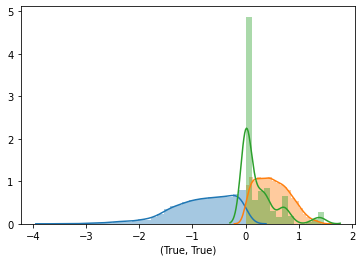

In [114]:
rm.groupby(['pruned_user','pruned']).surplus.apply(sns.distplot, norm_hist = True)

In [150]:
rides['indexes_set']=rides.indexes.apply(set)

0                            {0}
1                            {1}
2                            {2}
3                            {3}
4                            {4}
                  ...           
1821     {32, 37, 8, 48, 89, 57}
1822    {32, 37, 48, 49, 89, 57}
1823     {32, 37, 8, 48, 89, 57}
1824     {32, 37, 8, 48, 49, 89}
1825    {32, 37, 48, 49, 89, 57}
Name: indexes, Length: 1826, dtype: object

In [167]:
rides.loc[1825].subgroups

array([  32,   37,   48,   49,   57,   89,  134,  138,  178,  179,  188,
        190,  302,  352,  355,  356,  359,  428,  431,  432,  434,  447,
        448,  450,  452,  453,  614,  618,  723,  728,  731,  732,  733,
        738,  740,  741,  754,  759,  762,  763,  775,  776,  778,  779,
        869,  870,  979,  980,  988,  989,  993,  994,  995, 1086, 1091,
       1094, 1095, 1096, 1101, 1103, 1104, 1108, 1109, 1130, 1135, 1138,
       1139, 1151, 1152, 1154, 1155, 1160, 1161, 1329, 1430, 1432, 1433,
       1455, 1456, 1459, 1460, 1464, 1466, 1467, 1476, 1477, 1485, 1487,
       1488, 1506, 1507, 1517, 1519, 1520, 1525, 1526, 1535, 1578, 1580,
       1581, 1597, 1598, 1600, 1601, 1605, 1607, 1608, 1619, 1620, 1623,
       1624, 1631, 1633, 1634, 1653, 1654, 1669, 1671, 1672, 1679, 1680,
       1681, 1742, 1743, 1746, 1747, 1755, 1756, 1765, 1766, 1767, 1779,
       1780, 1787, 1788, 1793, 1803, 1804, 1805, 1806, 1813, 1814, 1818,
       1822, 1825])

In [149]:
r = inData.sblts.rides.iloc[-3]
rides[rides.indexes.apply(lambda x: set(r.indexes).issubset(set(x)))].index

def givemesubsets(row):
    return rides[rides.indexes.apply(lambda x: set(x).issubset(set(row.indexes)))].index.values
rides['subgroups'] = rides.apply(givemesubsets, axis = 1)

In [180]:
price_column ='uniform_split'
G = 1825
H = 1460
df = rm.loc[H,:][[price_column]].join(rm.loc[G,:][[price_column]], lsuffix='_G',rsuffix='_H')
df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
return df.surplus.max()>0

,uniform_split_G,uniform_split_H,surplus
32,3.10765,2.794692,0.312958
48,3.10765,2.794692,0.312958
57,3.10765,2.794692,0.312958
89,3.10765,2.794692,0.312958


In [195]:
rm = inData.sblts.rides_multi_index
rides = inData.sblts.rides

def hermetic(ride):
    G = ride.name  
    prices_G = rm.loc[G,:][[price_column]]
    hermetic = True
    for H in ride.subgroups:       
        # determine whether there exists at least one traveller who wants to use G rather than H
        df = rm.loc[H,:][[price_column]].join(prices_G, lsuffix='_H',rsuffix='_G')
        df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
        if df.surplus.max()<0:
            hermetic = False   
            break
    return hermetic

rides['hermetic'] = rides.apply(hermetic,axis = 1)   

In [198]:
rides.groupby('hermetic').size()

hermetic
False    1712
True      114
dtype: int64

In [ ]:
def group_domimancy(rm, G,H):
    # determine whether there exists at least one traveller who wants to use G rather than H
    df = rm.loc[H,:][[price_column]].join(rm.loc[G,:][[price_column]], lsuffix='_G',rsuffix='_H')
    df['surplus'] = df.iloc[:,0]-df.iloc[:,1]
    return df.surplus.max()>0


In [163]:
r = rides.loc[1562]
r[['indexes','subgroups']]
rides.loc[r.subgroups[13]].indexes, r.indexes

([31, 2, 53], [31, 2, 53, 44])

In [133]:
rides = inData.sblts.rides
other_indexes = rides.indexes.copy()
for i, ride in rides.iterrows():
    indexes = ride.indexes
    

In [106]:
rm.tail(10)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
1824 37  1824         37    True       6    66       718  2181    272   
     89  1824         89    True       6   147       718  2304    288   
     8   1824          8    True       6    11       718  3505    438   
     49  1824         49    True       6    81       718  1812    226   
1825 32  1825         32    True       6    52       718  3427    428   
     48  1825         48    True       6    80       718  3438    429   
     37  1825         37    True       6    66       718  2181    272   
     89  1825         89    True       6   147       718  2304    288   
     57  1825         57    True       6    98       718  3027    378   
     49  1825         49    True       6    81       718  1812    226   

         ttrav_sh  delay distance cost_veh  cost_user  price_single  \
1824 37       436   48.5     5744   3.7695     1.8655       2.38000   
     89       489   29.5     5744   3.7695     1.9180       2.52000   
     8        543  226.5     5744   3.7695     3.4860       3.83250   
     49       462  237.5     5744   3.7695     3.2795       1.97750   
1825 32       611   10.5     5744   3.7695     2.2120       3.74500   
     48       589    4.5     5744   3.7695     2.0930       3.75375   
     37       444   48.5     5744   3.7695     1.8935       2.38000   
     89       497   29.5     5744   3.7695     1.9460       2.52000   
     57       538  144.5     5744   3.7695     2.8945       3.30750   
     49       454  245.5     5744   3.7695     3.3075       1.97750   

         uniform_split  pruned_user  pruned   surplus  
1824 37       3.094583        False   False -0.714583  
     89       3.094583        False   False -0.574583  
     8        3.094583         True   False  0.737917  
     49       3.094583        False   False -1.117083  
1825 32       3.019333         True   False  0.725667  
     48       3.019333         True   False  0.734417  
     37       3.019333        False   False -0.639333  
     89       3.019333        False   False -0.499333  
     57       3.019333         True   False  0.288167  
     49       3.019333        False   False -1.041833

In [82]:
rm.tail(10)

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
1824 37  1824         37    True       6    66       718  2181    272   
     89  1824         89    True       6   147       718  2304    288   
     8   1824          8    True       6    11       718  3505    438   
     49  1824         49    True       6    81       718  1812    226   
1825 32  1825         32    True       6    52       718  3427    428   
     48  1825         48    True       6    80       718  3438    429   
     37  1825         37    True       6    66       718  2181    272   
     89  1825         89    True       6   147       718  2304    288   
     57  1825         57    True       6    98       718  3027    378   
     49  1825         49    True       6    81       718  1812    226   

         ttrav_sh  delay distance cost_veh  cost_user  costs_user  costs_veh  \
1824 37       436   48.5     5744   30.156     1.8655         NaN        NaN   
     89       489   29.5     5744   30.156     1.9180         NaN        NaN   
     8        543  226.5     5744   30.156     3.4860         NaN        NaN   
     49       462  237.5     5744   30.156     3.2795         NaN        NaN   
1825 32       611   10.5     5744   30.156     2.2120         NaN        NaN   
     48       589    4.5     5744   30.156     2.0930         NaN        NaN   
     37       444   48.5     5744   30.156     1.8935         NaN        NaN   
     89       497   29.5     5744   30.156     1.9460         NaN        NaN   
     57       538  144.5     5744   30.156     2.8945         NaN        NaN   
     49       454  245.5     5744   30.156     3.3075         NaN        NaN   

         price_single  
1824 37        0.9520  
     89        1.0080  
     8         1.5330  
     49        0.7910  
1825 32        1.4980  
     48        1.5015  
     37        0.9520  
     89        1.0080  
     57        1.3230  
     49        0.7910

In [316]:
pruned = rides.groupby('ride')['pruned_user'].min().to_frame('pruned')
pruned['ride'] = pruned.index
rides['pruned'] = rides.join(pruned['pruned'], on = 'ride')
rides.groupby('ride')

,ride
ride,
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True


In [62]:
def calc_delay(r):
    deps = [r.times[0]]
    for d in r.times[1:r.degree]:
        deps.append(deps[-1]+d) # departure times
    t = inData.sblts.requests
    return deps
inData.sblts.rides.apply(calc_delay, axis = 1)
inData.sblts.rides[]

0                        [0]
1                        [1]
2                        [2]
3                       [28]
4                       [42]
5                       [52]
6                       [69]
7                       [83]
8                      [155]
9                      [163]
10             [-21.0, 88.0]
11               [6.5, 91.5]
12            [-96.0, 112.0]
13              [-3.5, 88.5]
14           [-165.5, 345.5]
15              [15.5, 43.5]
16            [-34.0, 102.0]
17            [-17.5, 153.5]
18              [-3.5, 88.5]
19             [43.0, 107.0]
20             [11.5, 167.5]
21              [7.0, 240.0]
22               [6.5, 91.5]
23              [9.5, 161.5]
24           [-130.0, 147.0]
25           [-144.5, 189.5]
26              [15.5, 43.5]
27           [-113.0, 182.0]
28            [-85.5, 185.5]
29             [43.0, 107.0]
30             [75.0, 164.0]
31      [-21.0, 88.0, 152.0]
32     [-34.0, 102.0, 194.0]
33        [6.5, 91.5, 155.5]
34    [-130.0,

In [68]:
R = inData.sblts.rides
r = R.sample(1).squeeze()
r.treqs - r.deps, r.deps, r.treqs

(array([-6.5, -8.5]), [6.5, 91.5], array([ 0, 83]))

In [43]:
t = inData.sblts.requests
treqs = list(t.loc[r.indexes_orig].treq.values)
deps[:len(r.indexes_dest)], treqs
[treq-deps[i] for i,treq in enumerate(treqs)]

[69.5, -84.5]

In [6]:
inData.sblts.requests

,index,origin,destination,treq,tdep,ttrav,tarr,tdrop,dist,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
0,5,1658828034,44996090,0,NaN,164,2020-09-25 17:20:42,NaN,1317,5,0.0035,179.241758,2.5495,999999,11,198,1.918225,20,0
1,6,44989210,1658828038,1,NaN,206,2020-09-25 17:26:15,NaN,1649,6,0.0035,224.274725,3.1945,999999,20,209,2.945275,20,1
2,9,45021401,2502729245,2,NaN,501,2020-09-25 18:05:35,NaN,4008,9,0.0035,545.043956,7.7655,999999,26,580,5.774675,21,0
3,1,45024107,2502710368,28,NaN,141,2020-09-25 17:18:08,NaN,1135,1,0.0035,154.549451,2.1960,999999,3,141,2.196000,1,0
4,4,45024108,510614415,42,NaN,236,2020-09-25 17:30:57,NaN,1890,4,0.0035,257.076923,3.6610,999999,26,236,2.552725,21,1
5,2,5040974850,4818737407,52,NaN,156,2020-09-25 17:20:28,NaN,1251,2,0.0035,170.208791,2.4225,999999,17,171,2.032525,20,0
6,7,4818737407,44993506,69,NaN,232,2020-09-25 17:30:54,NaN,1860,7,0.0035,253.054945,3.6020,999999,17,232,2.835075,20,1
7,8,45003346,44994279,83,NaN,123,2020-09-25 17:16:33,NaN,985,8,0.0035,133.978022,1.9080,999999,11,160,1.564575,20,1
8,10,45023679,45022840,155,NaN,96,2020-09-25 17:14:09,NaN,769,10,0.0035,104.604396,1.4895,999999,8,96,1.489500,1,0
9,3,2502729230,1665808438,163,NaN,260,2020-09-25 17:36:08,NaN,2080,3,0.0035,282.857143,4.0300,999999,20,274,3.496025,20,0


### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

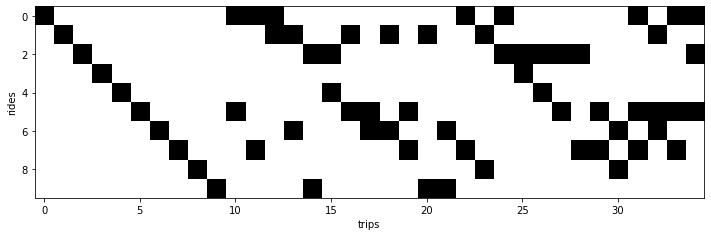

In [7]:
mtx = np.vstack(inData.sblts.rides['row'].values).T  # creates a numpy array for the constrains
m = pd.DataFrame(mtx).astype(int)
plt.rcParams['figure.figsize'] = [12, int(12*inData.sblts.rides.shape[0]/inData.requests.shape[0])]
fig, ax = plt.subplots()
ax.imshow(m, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
m.index.name = 'trips'
m.columns.name = 'rides'
inData.sblts.m = m

In [8]:
ret = dict()
sums = mtx.sum(axis=0)
for i in range(mtx.shape[1]): # chech this ride
    ret[i] = list()
    for j in range(mtx.shape[1]): # if other rides are contained with it
        if j != i: # if they are different
            if sums[j]<sums[i]: # and of lower degree               
                if sum(mtx[:,j]*mtx[:,i]) == sums[j]: # and the contiaining ride j contains all travellers of contained ride i
                    ret[i].append(j) # append for a dict 
inData.sblts.rides['subrides'] = pd.Series(ret)

### costs for system optima (column sums)
* passengers ('u_pax')
* vehicle ('u_veh')

In [8]:
inData.sblts.rides[['u_pax','u_veh']].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
u_pax,2.5495,3.1945,7.7655,2.196,3.661,2.4225,3.602,1.908,1.4895,4.03,3.96895,3.4828,5.0728,5.90775,10.1716,8.4184,5.4419,4.8676,6.15345,3.5607,6.4413,7.40035,3.5556,4.1613,8.98965,9.1307,8.3274,8.83095,7.7169,3.4879,4.10115,6.3912,8.3657,6.47993,11.9026
u_veh,164,206,501,141,236,156,232,123,96,260,317,260,416,470,858,592,469,418,432,234,380,512,266,403,670,725,595,688,575,257,360,388,591,395,801


### costs for single passengers

In [9]:
m_user_costs = m.copy()
for col in m.columns:
    new_col = [0]*params.nP
    indexes = inData.sblts.rides.loc[col]['indexes']
    u_paxes = inData.sblts.rides.loc[col].u_paxes
    for l,i in enumerate(indexes):
        new_col[i] = u_paxes[l]
    m_user_costs[col] = new_col
m_user_costs = m_user_costs.round(1)
m_user_costs

rides,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
trips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.9,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,2.3,0.0,0.0,0.0,0.0,0.0,0.0,2.4,0.0,2.4,2.4
1,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,2.8,0.0,0.0,3.1,0.0,3.1,0.0,2.9,0.0,0.0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.8,0.0,0.0
2,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.3,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,7.0,5.8,6.7,6.0,0.0,0.0,0.0,0.0,0.0,7.2
3,0.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.3,2.0,0.0,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,2.1,0.0,2.4,2.3,2.3,2.3
6,0.0,0.0,0.0,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,0.0,2.8,3.0,0.0,0.0,3.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,3.3,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0,1.7,1.3,0.0,1.7,0.0,1.8,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### ranking

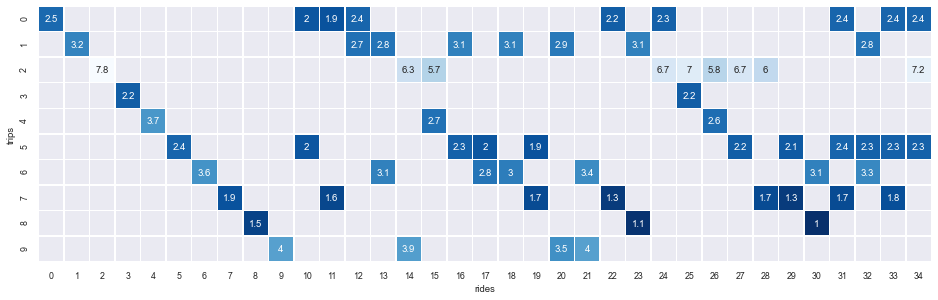

In [10]:
m_user_costs = m_user_costs.replace(0, np.nan)
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize = (16,16))
_ = sns.heatmap(m_user_costs, annot=True, mask = m_user_costs == np.nan , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

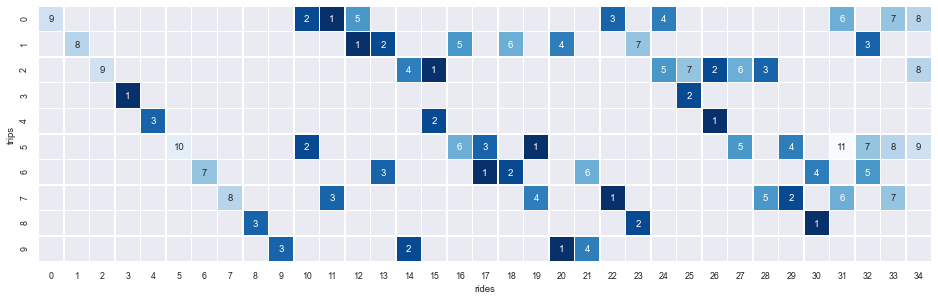

In [11]:
ranking = m_user_costs.replace(0, np.nan).rank(1, ascending = True, method = 'first')
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize = (16,16))
_ = sns.heatmap(ranking, annot=True, mask = m_user_costs == np.nan , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

### probabilities

apply simple logit model with high $\beta$  

<AxesSubplot:xlabel='rides', ylabel='trips'>

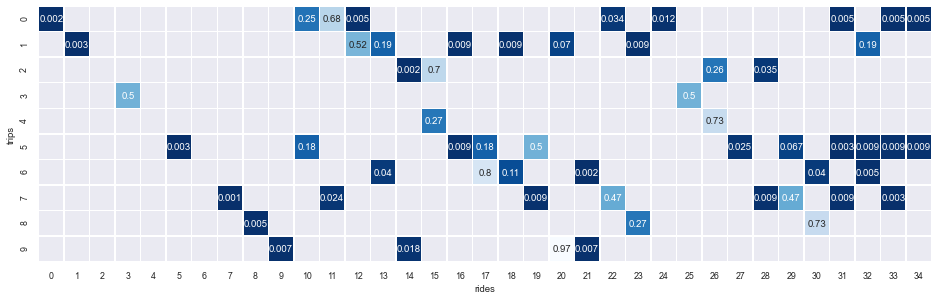

In [12]:
beta = -10 # behavioural parameter

probs = m_user_costs.replace(0,np.inf) # set rides without this pax to inf
probs = probs.applymap(lambda x: math.exp(beta*x))  # calculate exp to MNL
probs = probs.div(probs.sum(axis=1), axis =0).round(3) # divide by sum of utilities
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(probs, annot=True, mask = probs == 0 , cbar = False, ax = ax, square = True, cmap = 'Blues_r', linewidths=.5)

---
# PoA in ILP
---

compute PoA

In [18]:
def calc_solution_PoA(inData):
    indexes = dict()
    utilities = dict()
    for _ in inData.sblts.requests.index:
        indexes[_] = list()
        utilities[_] = list()
    for i,row in inData.sblts.rides.iterrows():
        for j,traveller in enumerate(row.indexes):
            indexes[traveller] += [i]
            utilities[traveller] += [row.u_paxes[j]]

    inData.sblts.requests['ride_indexes'] = pd.Series(indexes)
    inData.sblts.requests['ride_utilities'] = pd.Series(utilities)
    inData.sblts.requests['min_utility'] = inData.sblts.requests['ride_utilities'].apply(lambda x: min(x))
    inData.sblts.requests['PoA'] = inData.sblts.requests['u_sh'] - inData.sblts.requests['min_utility']
    inData.sblts.requests['PoA_relative'] = (inData.sblts.requests['u_sh'] - inData.sblts.requests['min_utility'])/inData.sblts.requests['min_utility']
    #inData.sblts.requests['ranking'] = inData.sblts.requests.apply(lambda x: int(ranking.loc[x.name][x.ride_id]),axis =1)
    return inData


In [19]:
inData.sblts.rides['degree'] = inData.sblts.rides.apply(lambda x: len(x.indexes),axis = 1)
inData.sblts.rides['rankings'] = inData.sblts.rides.apply(lambda ride: [int(ranking.loc[traveller][ride.name]) for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_ranking'] = inData.sblts.rides.apply(lambda ride: sum(ride.rankings) / ride.degree,axis = 1)
rel_ranking = ranking.div(ranking.max(axis=1),axis = 0)
inData.sblts.rides['rel_rankings'] = inData.sblts.rides.apply(lambda ride: [rel_ranking.loc[traveller][ride.name] for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_rel_ranking'] = inData.sblts.rides.apply(lambda ride: sum(ride.rel_rankings) / ride.degree,axis = 1)
inData.sblts.rides['PoA'] = inData.sblts.rides.apply(lambda ride: [m_user_costs.loc[traveller][ride.name]-m_user_costs.loc[traveller].min() for traveller in ride.indexes],axis = 1)
inData.sblts.rides['mean_PoA'] = inData.sblts.rides.apply(lambda ride: sum(ride.PoA) / ride.degree,axis = 1)
inData.sblts.rides['total_PoA'] = inData.sblts.rides.apply(lambda ride: sum(ride.PoA) / ride.degree,axis = 1)

pricing in the group

In [28]:
df = inData.sblts.schedule.loc[26:26][['indexes','u_pax','u_paxes','u_veh','PassHourTrav_ns']]
df.index.name = 'group id'
df.columns = ['travellers','disutilities, total', 'disutilities, per traveller', 'total travel time shared', 'total travel time non shared']
df

,travellers,"disutilities, total","disutilities, per traveller",total travel time shared,total travel time non shared
group id,,,,,
26,"[2, 4]",8.3274,"[5.774675, 2.552725]",595,737


In [24]:
df = inData.sblts.requests.loc[[2,4]][['u_sh','u','ttrav_sh','ttrav']]
df.columns = [['disutility in the shared ride', 'disutility in the non-shared ride', 'travel time shared','travel time non_shared']]
df.index.name = 'traveller'
df

,disutility in the shared ride,disutility in the non-shared ride,travel time shared,travel time non_shared
traveller,,,,
2,5.774675,7.7655,580,501
4,2.552725,3.6610,236,236


### Solution: system optimal for user costs ('u_pax')

In [31]:
def test_obj_fun(inData, obj = 'u_pax', _plot = True):
    params.matching_obj = obj
    inData = matching(inData, params, plot = False)
    if _plot:
        m_solution = inData.sblts.m.copy()
        fig, ax = plt.subplots()
        for col in m_solution.columns:
            if inData.sblts.rides.loc[col].selected==0:
                m_solution[col] = m[col]
            else:
                m_solution[col] = m[col]*5

        ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
        ax.set_ylabel('rides')
        _ = ax.set_xlabel('trips')
        print('grey - feasible, black - selected')
    inData = calc_solution_PoA(inData)
    return inData.sblts.requests.PoA.sum()
ret=dict()
for obj in ['u_pax', 'u_veh','total_PoA', 'mean_PoA', 'mean_rel_ranking']:
    ret[obj]=test_obj_fun(inData, obj = obj, _plot = False)
pd.Series(ret,name='PoA').to_frame()

,PoA
u_pax,1.190525
u_veh,2.924325
total_PoA,2.022700
mean_PoA,2.022700
mean_rel_ranking,1.931700


grey - feasible, black - selected


(1.190525000000001, 0.8057705796471463)

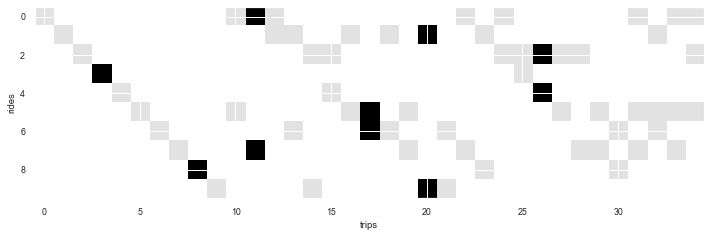

### Solution: system optimal for operator costs ('u_veh')

grey - feasible, black - selected


(2.9243250000000005, 1.6101323015426394)

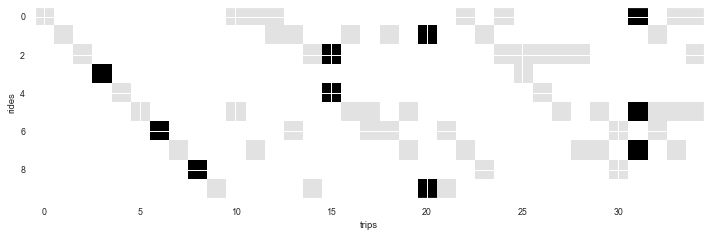

In [16]:
params.matching_obj = 'u_veh'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(2.0227, 1.0596280933754736)

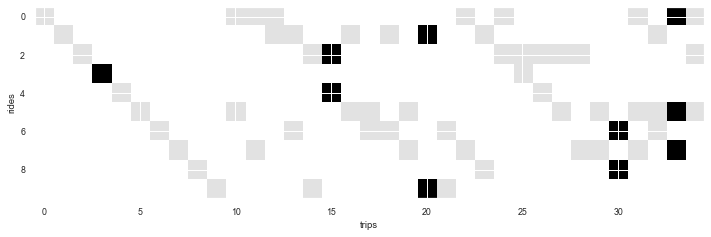

In [17]:
params.matching_obj = 'total_PoA'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(2.0227, 1.0596280933754736)

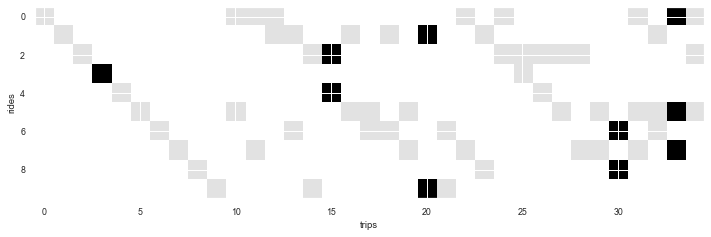

In [18]:
params.matching_obj = 'mean_PoA'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

grey - feasible, black - selected


(1.931700000000001, 1.0062832083627762)

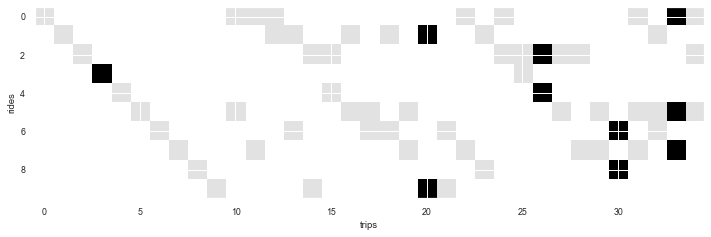

In [19]:
params.matching_obj = 'mean_rel_ranking'
inData = matching(inData, params, plot = False)
m_solution = m.copy()
fig, ax = plt.subplots()
for col in m.columns:
    if inData.sblts.rides.loc[col].selected==0:
        m_solution[col] = m[col]
    else:
        m_solution[col] = m[col]*5
ax.imshow(m_solution, cmap='Greys', interpolation = 'Nearest')
ax.set_ylabel('rides')
_ = ax.set_xlabel('trips')
print('grey - feasible, black - selected')
inData = calc_solution_PoA(inData)
inData.sblts.requests.PoA.sum(), inData.sblts.requests.PoA_relative.sum()

### KPIs for two solutions

In [20]:
KPIs['u_veh'] = inData.sblts.res
KPIs['description']  = ExMAS.utils.KPIs_descriptions
KPIs

,u_pax,u_veh,description
VehHourTrav,1830,1830,total travel time of vehicles (with travellers...
VehHourTrav_ns,2115,2115,as above yet in non-shared scenarion
PassHourTrav,2297,2297,total travel time of passengers
PassHourTrav_ns,2115,2115,as above yet in non-shared scenarion
PassUtility,26.8046,26.8046,total (dis)utility of passengers
PassUtility_ns,32.8185,32.8185,as above yet in non-shared scenarion
mean_lambda,0.119808,0.119808,mean vehicle cost reduction (lambda) over shar...
revenue_s,1586.25,1586.25,total fares paid by travellers sharing
revenue_ns,3172.5,3172.5,as above yet in non-shared scenarion
Fare_Discount,-0.5,-0.5,relative revenue reduction


---
(c) Rafał Kucharski, Delft, 2020